# Linear model and neural network from scratch

In this notebook we are building a model without anything pre built. <br>
For data we use the Titanic competition. <br>
For sake of simplicity the data is in the CSV/Titanic folder

We are using numpy and pytorch for calculations and pandas for working with tabular data

In [1]:
import numpy as np, pandas as pd, torch

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)
path="CSV/Titanic"

## Cleaning the data
The data is in a table, provided via CSV file. We can use `pandas` to load the data

In [2]:
df = pd.read_csv(path+"/train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


We are gonna multiply each column by some coefficient and `NaN` wont cut it. (NaN - Not a number, missing value) <br>
Lets check how much NaNs are in the data

In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We are using the most common value (`mode`) to replace all the `NaNs`

In [4]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [5]:
df.fillna(modes, inplace=True)

In [6]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Lets see a quick summary of the data

In [7]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see the `Fare` is mainly between 0 and 30, but there are some big ones  (min to 75% is mostly between 0 and 30) but with some big values the model will be dominated. <br>
We can see the issue with a histogram

<Axes: >

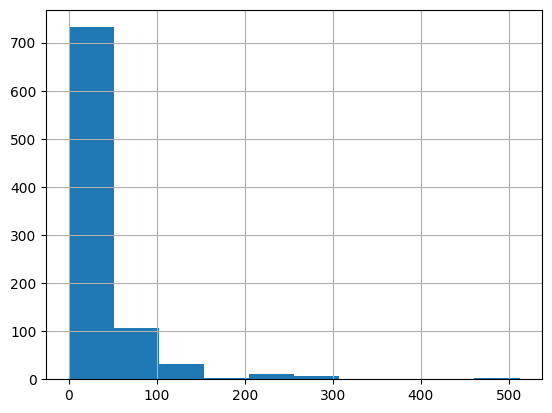

In [8]:
df['Fare'].hist()

To fix it the most common approach is to take the log of the values

In [9]:
df['LogFare'] = np.log(df['Fare']+1)

<Axes: >

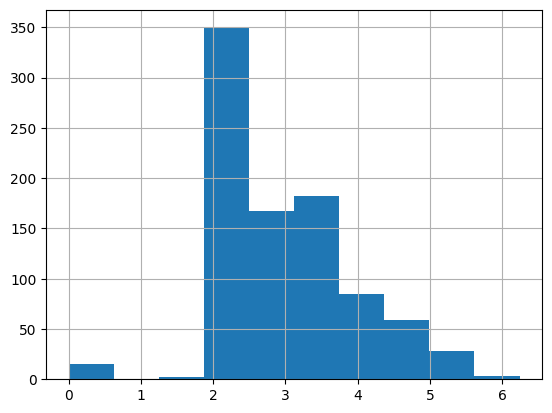

In [10]:
df['LogFare'].hist()

It looks like `Pclass` has only 3 values. We can check that

In [11]:
pclasses = sorted(df.Pclass.unique())
pclasses

[np.int64(1), np.int64(2), np.int64(3)]

Now a quick summary for the non numeric data

In [12]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,B96 B98,S
freq,1,577,7,691,646


We cannot multiply `male` or `s` by number so we need to to replace them with numbers. <br>
We can do it by creating dummy variables. Dummy variable is a column that contains 1 where a particular column contains a particular value, otherwise 0. <br>
For example with `Sex=male` we create a column in which there is 1 for each row in which for the column `Sex` has a value of `male`

We could use `get_dummies()` which also removes the OG columns. We will create dummy variables for `Pclass, Sex, Embarked`. For `Cabin, Name, Ticket` there are too much unique values so we wont make dummy variables for them

In [13]:
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

We can see that 8 col have been added, one for each value and the 3 cols have been removed

In [14]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False
2,False,True,False,False,True,False,False,True
3,False,True,True,False,False,False,False,True
4,True,False,False,False,True,False,False,True


We can create our independent (predictors) and depended (target) variables. They need to be PyTorch tensors. The depended variable in our case is `Survived`

In [15]:
from torch import tensor

t_dep = tensor(df.Survived)

Our independent variables are all continuous variables and the dummy variables we created

In [16]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
df[indep_cols].head()
t_indep = tensor(df[indep_cols].to_numpy(dtype=np.float32), dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [17]:
t_indep.shape

torch.Size([891, 12])

## Setting up a linear model

We are gonna create a simple linear model. We need coefficients for each `t_indep`. We pick random numbers between -0.5 and 0.5. 

In [18]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeff = torch.rand(n_coeff) - 0.5
coeff

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

We now multiply each row by the coeffitiens. We dont need bias because we cover the entire dataset.

In [19]:
t_indep*coeff

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

The sum is dominated by the first column. To fix this we divide every value in each columnby the max value of the column

In [20]:
vals, indices = t_indep.max(dim=0)
t_indep = t_indep / vals

Now we can multiply

In [21]:
t_indep * coeff

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

With `t_indep = t_indep / vals` we divide a matrix by a vector via broadcasting.

We can create the predictions

In [22]:
preds = (t_indep * coeff).sum(axis=1)

Lets see some of the predictions

In [23]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

These are starting predictions. We are gonna use them for gradient descent <br>
For gradient descent we need a loss function. We are using average error of rows

In [24]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

To make it easier we gonna create some functions

In [25]:
def calc_preds(coeffs, indeps): return (indeps * coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

## Doing gradient descent 

We are gonna do a singe "epoch" of GD manually. To calculate the gradient we use `required_grad_()` on the `coeff`

In [26]:
coeff.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

Now to calculate the loss

In [27]:
loss = calc_loss(coeff, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

We access the gradient with `.backward()`

In [28]:
loss.backward()

In [29]:
coeff.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

Each time we call `backward` the gradients are added to whatever is inside the `.grad` attribute. <br>
Lets try the above steps again

In [30]:
loss = calc_loss(coeff, t_indep, t_dep)
loss.backward()
coeff.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

The `.grad` values have doubled. Thats because the grad is added a second time. <br>
For that reason we need to set the gradient back to 0

In [31]:
loss = calc_loss(coeff, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeff.sub_(coeff.grad * 0.1)
    coeff.grad.zero_()
    print(calc_loss(coeff, t_indep, t_dep))

tensor(0.4945)


`a.sub_(b)` subtracts b from a in place. In pytorch every method that ends in `_` changes the object in place. Same goes for `a.zero_()`

## Training the linear model



We need to create a training and validation sets. We use `RandomSplitter`

In [32]:
from fastai.data.transforms import RandomSplitter
trainSplit, validationSplit = RandomSplitter(seed=42)(df)

We can apply the independent and dependent variables

In [33]:
trainIndep, validationIndep = t_indep[trainSplit], t_indep[validationSplit]
trainDep, validationDep = t_dep[trainSplit], t_dep[validationSplit]
len(trainIndep),len(validationIndep)

(713, 178)

We create a function to modify the coeffitiens

In [34]:
def update_coeff(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [35]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trainIndep, trainDep)
    loss.backward()
    with torch.no_grad():
        update_coeff(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [36]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

Lets create a method to train our model

In [37]:
def train_model(epochs = 30, lr = 0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr=lr)
    return coeffs

Lets test it

In [38]:
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

Lets see the coefficients for each collumn

In [39]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

## Measuring accuracy

Lets see how accurate we predict

In [40]:
preds = calc_preds(coeffs, validationIndep)

We assume if the prediction is over `0.5` the passenger survived, else he died.

In [41]:
results = validationDep.bool()==(preds >=0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

Average accuracy

In [42]:
results.float().mean()

tensor(0.7865)

We'll create a function to calculate accuracy easily

In [43]:
def acc(coeffs): return (validationDep.bool()==(calc_preds(coeffs, validationIndep)>0.5)).float().mean()

## Using sigmoid

Some of the predictions are `> 1` and some are `< 0`. To fix them we use a sigmoid

In [44]:
preds[:28]

tensor([ 0.8160,  0.1295, -0.0148,  0.1831,  0.1520,  0.1350,  0.7279,  0.7754,  0.3222,  0.6740,  0.0753,  0.0389,  0.2216,  0.7631,
         0.0678,  0.3997,  0.3324,  0.8278,  0.1078,  0.7126,  0.1023,  0.3627,  0.9937,  0.8050,  0.1153,  0.1455,  0.8652,  0.3425])

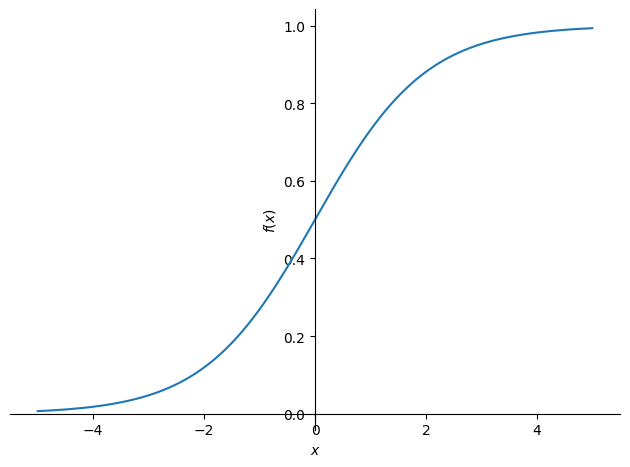

In [45]:
import sympy
from sympy.abc import x

expr = 1 / (1 + sympy.exp(-x))
sympy.plot(expr, (x, -5, 5))

We can modify the `calc_preds` method to use `torch.sigmoid`

In [46]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [47]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

We have imporved loss. Lets check the accuracy

In [48]:
acc(coeffs)

tensor(0.8258)

Lets see the coeffs

In [49]:
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

## Submit to Kaggle
We gonna skip this, because we not submiting to kaggle. The most import is that to fix the `NaN` problem its used `df.Fare.fillna(0)`

## Using matrix product

We can make it neater. The inner most calculation is similar to matrix-vector product. We can use `@` to indicate that we want matrix product, which is supported by PyTorch tensors. We can refactor the code like that

In [50]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

We need to convert the coeffs into a column vector (single column matrix). This can be achieved like that

In [51]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

We also need to make our variables be column vectors

In [52]:
trainDep = trainDep[:, None]
validationDep = validationDep[:, None]

Now we can train the model

In [53]:
coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [54]:
acc(coeffs)

tensor(0.8258)

Same coeffs, same accuracy

## Neural network

To use a NN we need to create coefficients for each layer. The first set will take the `n_coeff` and create `n_hidden` outputs. <br>
We need a matrix with `n_coeff` by `n_hidden` size. <br>
The second layer needs to take `n_hidden` number of inputs and create a single output, so we need a `n_hidden` by `1` matrix

In [55]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden) - 0.5)/ n_hidden
    layer2 = torch.rand(n_hidden, 1) - 0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

To create our NN we need two matrix product: `indeps@l1` and `res@l2`, res is the output of layer 1. <br>
The first layer output is passed to `F.relu` and the second is passed to `torch.sigmoid`

In [56]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

To update the coeffs we need a loop

In [57]:
def update_coeff(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Lets train it

In [58]:
coeffs = train_model(lr=1.4)

0.543; 0.532; 0.520; 0.505; 0.487; 0.466; 0.439; 0.407; 0.373; 0.343; 0.319; 0.301; 0.286; 0.274; 0.264; 0.256; 0.250; 0.245; 0.240; 0.237; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.221; 0.220; 

In [59]:
coeffs = train_model(lr=20)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [60]:
acc(coeffs)

tensor(0.8258)

## Deep learning

We can add matrix multiplication to the NN

In [69]:
def init_coeffs():
    hiddens = [10, 10]
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1]) - 0.3) / sizes[i + 1] * 4 for i in range(n-1)]
    consts = [(torch.rand(1)[0] - 0.5) * 0.1 for i in range(n-1)]
    for l in layers + consts: l.requires_grad_()
    return layers, consts

We need to update the `calc_preds` and `update_coeffs` methods

In [70]:
def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [73]:
def update_coeff(coeffs, lr):
    layers, consts = coeffs
    for layer in layers + consts:
        layer.sub_(layer.grad* lr)
        layer.grad.zero_()

We can train and check the accuracy

In [74]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [75]:
acc(coeffs)

tensor(0.8258)